In [3]:
# Preparamos todo para correr
import numpy as np
from math import *
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import norm, gamma, multivariate_normal, wishart


(array([ 4.03937977, 14.69498501, 19.77903195, 15.0432074 ,  9.05378223,
         4.10902424,  1.81075645,  0.76608927,  0.27857791,  0.06964448]),
 array([1.00597813, 1.02033677, 1.03469541, 1.04905405, 1.06341269,
        1.07777133, 1.09212997, 1.10648861, 1.12084725, 1.13520589,
        1.14956453]),
 <a list of 1 Patch objects>)

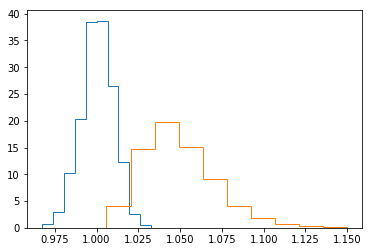

In [22]:
plt.hist(norm.rvs(loc=1,scale=0.01,size=1000),histtype='step',label='Gaussiana',density='True')
plt.hist(gamma.rvs(a=5.0, loc=1, scale=0.01,size=1000),histtype='step',label='Gaussiana',density='True')

# Vamos a dar un (breve) ejercicio de inferencia Bayesiana con Gaussianas

Voy a trabajar en el caso uni-dimensional (es decir, cada medición es una única variable aleatoria $x$).

Empecemos con un ejemplo de la vida cotidiana. Supongamos que quiero saber la altura de un edificio. La forma más práctica de hacerlo es juntar un grupo de diez personas y que cada uno mida 100 veces la altura del edificio. En lugar de ver las 100 mediciones de cada persona, puedo ver la media.  Asumiendo que, para cada persona, cada medición de la altura se hace independientemente de las otras (confio mucho en mi grupo) y que todos son bastante buenos midiendo, puedo pensar que la media sigue una distribución normal o gaussiana. Es decir que mi problema consiste en analizar los datos

$x_{i}$ con $i=1,...10$, donde $x_{i}=\sum_{j=1}^{100}\frac{x_{ij}}{100}$

Ahora, dado que $x_{i}$ sigue una distribución gaussiana, debo estimar los parametros $\mu$ y $\sigma$, que, si le pregunto al ingeniero, sabría que es $\mu = 12$ y $\sigma=0.4$ (todo está en metros) 

Text(0, 0.5, 'Altura [m]')

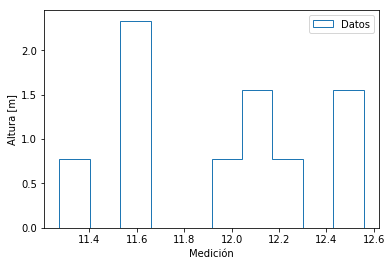

In [68]:
N_obs=10
mu_true=12
sigma_true=0.4
X=norm.rvs(loc=mu_true,scale=sigma_true,size=N_obs)
plt.hist(X,histtype='step',label='Datos',density='True')
plt.legend(loc='upper right')
plt.xlabel('Medición')
plt.ylabel('Altura [m]')


Si la variable sigue una distribución normal, sabemos que la verosimilitud de los datos es

$P(\vec{x}|\mu,\sigma^2)=\prod_{i=1}^{N}\frac{1}{(2\pi\sigma^2)^{1/2}}e^{-\frac{(x_{i}-\mu)^2}{2\sigma^2}}$

El estimador frecuentista viene de maximizar esta verosimilitud, obteniendo

$\mu_{ML}=\frac{1}{N}\sum_{i=1}^{N}x_{i}$

$\hat{\sigma}^{2}_{ML}=\frac{1}{N-1}\sum_{i=1}^{N}(x_{i}-\mu_{ML})^{2}$

Donde corregimos el estimador de la varianza para evitar el sesgo

In [69]:
mu_ML=np.mean(X)
print(mu_ML)
sigma_ML=np.sqrt(np.var(X, ddof=1))
print(sigma_ML)

11.951985615506505
0.41954129114913835


Para volver esto un problema bayesiano, podemos ir metiendonos un dedo a la vez.

Como primer intento, asumamos que conocemos la varianza de la variable. Si quieren, conocemos que la incerteza intrinseca viene de efectos de dilatación térmica del edificio y de paralaje en la observación. Sin embargo, asumimos que sabemos que, por la zona, la altura debe ser del orden de, aproximadamente, 10 metros. Y, como quiero poder hacer todo análiticamente, utilizo un prior normal con una varianza de 0.5 metros.

$P(\mu|\mu_{0},\sigma^{2}_{0})=\mathcal{N}({\mu|\mu_0,\sigma^{2}_{0}})$

Haciendo las cuentas puedo ver que el posterior va a tener la forma de una Gaussiana $\mathcal{N}({\mu|\mu_{N},\sigma^{2}_{N}})$ con

$\mu_{N}=\frac{\sigma^2}{\sigma^2+N\sigma^{2}_{0}}\mu_{0}+\frac{N\sigma^{2}_{0}}{\sigma^2+N\sigma^{2}_{0}}\mu_{ML}$

$\frac{1}{\sigma^{2}_{N}}=\frac{1}{\sigma^{2}_{0}}+\frac{N}{\sigma^2}$

Donde se ve que, para $N$ grande, $\mu$ tiende al valor de $\mu_{ML}$ y $\sigma_{N}$ a $\sigma_{0}$. Otra cosa a notar que es la notación es más comoda si introducimos la _precisión_ $\lambda = \frac{1}{\sigma^2}$.

Este resultado se obtiene análiticamente. Aunque existen trucos que la obvien en el calculo del posterior, también puede calcularse la evidencia.

$P(\vec{x}|\sigma^{2},\mu_{0},\sigma^{2}_{0})=\prod_{i}p(x_{i}|\sigma^{2},\mu_{0},\sigma^{2}_{0})=\prod_{i}\int d\mu P(x_{i}|\mu,\sigma^{2})P(\mu|\mu_{0},\sigma^{2}_{0})$

Una materia de hacerlo es notar que, para este caso simple, $p(x_{i}|\sigma^{2},\mu_{0},\sigma^{2}_{0})=\mathcal{N}(x_{i}|\mu_{0},\sigma^{2}_{0}+\sigma^{2})$.

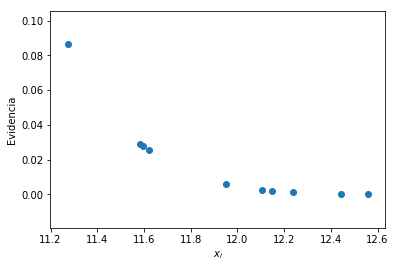

11.834577441613032 0.00022588322275874062


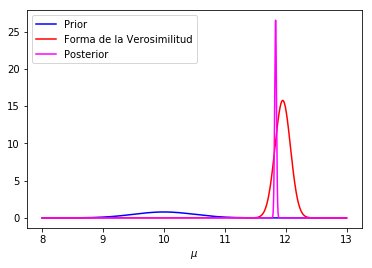

In [150]:
mu_0=10
sigma_0=0.5
evidence=norm.pdf(X,mu_0,np.sqrt(sigma_0**2+sigma_true**2))
plt.scatter(X,evidence)
plt.ylabel('Evidencia')
plt.xlabel('$x_{i}$')
plt.show()

mu=np.linspace(8,13,100000)
prior=norm(loc=mu_0,scale=sigma_0)
plt.plot(mu,prior.pdf(mu),color='blue',label='Prior')

verosimilitud_aux=list(map(lambda x: norm.pdf(x,mu,sigma_true*np.ones(len(mu))),X))
verosimilitud=np.prod(verosimilitud_aux,axis=0)
#verosimilitud=np.prod(norm.pdf(X,mu,sigma_0))
plt.plot(mu,100000*verosimilitud/np.sum(verosimilitud),color='red',label='Forma de la Verosimilitud')


mu_N=mu_0*(sigma_true**2)/(N_obs*(sigma_0)**2+sigma_true**2)+mu_ML*(N_obs*sigma_0**2)/(N_obs*(sigma_0)**2+sigma_true**2)
sigma_N=1/(1/sigma_0**2+N_obs/sigma_true**2)
posterior=norm(loc=mu_N,scale=sigma_N)
plt.plot(mu,posterior.pdf(mu),color='magenta',label='Posterior')
plt.xlabel('$\mu$')
plt.legend(loc='upper left')

print(np.mean(posterior.rvs(size=100000)),np.var(posterior.rvs(size=100000)))

Sin embargo, aca estamos haciendo una hipotesis que quizás no nos gusta. Asumimos conocer la varianza. ¿Qué pasa si queres inferir la varianza? Viendo la forma de la verosimilitud, se puede ver que es más fácil trabajar con la precisión. Reescribiendo la verosimitilud en función de $\lambda$ vemos que los términos relevantes son:

$P(\vec{x}|\mu,\lambda) \propto \lambda^{\frac{N}{2}}e^{-\frac{\lambda}{2}\sum_{i=1}^{N}(x_{i}-\mu)^2}$

que tiene como prior conjugado la distribución Gam$(\alpha,\beta)$.

$P(\lambda | \alpha, \beta) = \frac{\beta^{\alpha}\lambda^{\alpha-1}e^{-\beta\lambda}}{\Gamma(\alpha)}$

Esta función está definida para $\lambda, \alpha, \beta > 0$. $\alpha/\beta$ será la media de la distribución y $\alpha/\beta^{2}$ la varianza. Al elegir un prior conjugado y jugar un poco, podemos que el posterior va a seguir una distribución Gam$(\lambda |\alpha_{N},\beta_{N})$ con:

$\alpha_{N}=\alpha_{0}+\frac{N}{2}$

$\beta_{N}=\beta_{0}+\frac{N}{2}\sigma^{2}_{ML}$

Viendo los parametros del posterior, vemos que $\alpha_{0}$ juega el rol de $2N$ mediciones (imaginarias) previas. 

A la hora de implementar esto númericamente, dos cosas a tener en cuenta. Yo escribi $\beta_{N}$ en función de $\sigma_{ML}$ sin corregir el sesgo, por lo que no hay que meter el calculado anteriormente a lo bestia. Además, hay que revisar la documentación de scipy.stats de la función gamma para ver que ellos utilizan el parametro scale, equivalente a $\beta^{-1}$.

Aquí el calculo de la evidencia no es tan trivial, y la resolución análitica por suerte dispensa de ella.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


0.6719841134784428 0.07626627253029261


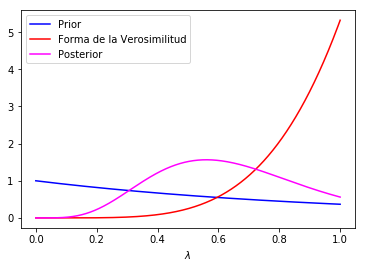

In [151]:
alpha_0=1.0
beta_0=1.0


lambda_val=np.linspace(0,1.0,100000)
prior=gamma(a=alpha_0,loc=0.0,scale=1/beta_0)
plt.plot(lambda_val,prior.pdf(lambda_val),color='blue',label='Prior')
sigma_val=[np.sqrt(1/lambda_val[i]) for i in range(len(lambda_val))]

verosimilitud_aux=list(map(lambda x: norm.pdf(x,mu_true*np.ones(len(lambda_val)),sigma_val),X))
verosimilitud=np.prod(verosimilitud_aux,axis=0)
plt.plot(lambda_val,100000*verosimilitud/np.sum(verosimilitud),color='red',label='Forma de la Verosimilitud')


alpha_N=alpha_0+N_obs/2
beta_N=beta_0+(N_obs/2)*(sigma_ML**2*(N_obs-1))

posterior=gamma(a=alpha_N,loc=0.0,scale=1/beta_N)

print(np.mean(posterior.rvs(size=100000)),np.var(posterior.rvs(size=100000)))
plt.plot(lambda_val,posterior.pdf(lambda_val),color='magenta',label='Posterior')
plt.xlabel('$\lambda$')
plt.legend(loc='upper left')

Finalmente, ¿que pasaría si quiero combinar ambas inferencias?

Bueno, viendo la forma de la verosimilitud vemos que podemos escribir un prior (ver página 101 del Bishop para más detalle) de la siguiente manera:

$P(\mu,\lambda) = P(\mu|\lambda)p(\lambda) = \mathcal{N}(\mu|\mu_{0},((2\alpha_{0}-1)\lambda)^{-1})$Gam$(\lambda|\alpha_{0},\beta_{0})$

Esta distribución se llama la distribución Gaussiana-Normal. Por cómo la definimos, el prior en $\mu$ depende de la precisión $\lambda$ de manera condicionada. Esta interacción entre ambos valores siempre estará presente. El problema se vuelve entonces relativamente más complicado. La evolución de los coeficientes se puede ver de manera análitica, agrupando términos de manera inteligente para llegar a que:

$\alpha_{N}=\alpha_{0}$

$\mu_{N}=\frac{N}{N+2\alpha_{0}-1}\mu_{ML}+\frac{2\alpha_{0}-1}{N+2\alpha_{0}-1}\mu_{0}$

Donde se observa que, para $N$ pequeños, $\mu_{N}$ se parece a $\mu_{0}$ y para $N$ grandes tiende a $\mu_{ML}$. Además, aparece la interacción con $\alpha_{0}$. Para $\beta_{N}$, queda más lindo escribir la ecuación intrinseca

$\mu^{2}_{N}+\frac{2\beta_{N}}{N+2\alpha_{0}-1}=\frac{1}{N+2\alpha_{0}-1}(N\mu^{2}_{ML}N\sigma^{2}_{ML}+(2\alpha_{0}-1)(\mu^{2}_{0}+\frac{2\beta_{0}}{2\alpha_{0}-1}))$

De donde no es trivial despejar $\beta_{N}$ (y no nos interesa para resolver el ejercicio númericamente.

Para plottear esto vemos que ya empezamos a enfrentarnos al problema de la dimensionalidad. Si antes tomabamos $D$ puntos para evaluar numericamente, ahora tenemos $D^2$.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
No handles with labels found to put in legend.


(50, 50)


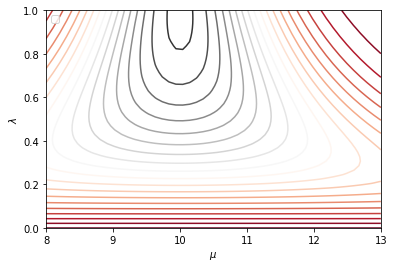

No handles with labels found to put in legend.


(50, 50)


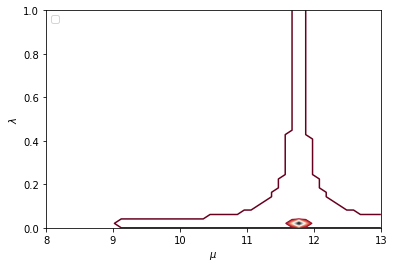

In [168]:
alpha_0=1.0
beta_0=1.0
mu_0=10

def gaussian_gamma(x,y, mu,alpha,beta):
    return norm.pdf(x,loc=mu,scale=1/(y*beta))*gamma.pdf(y,a=alpha,loc=0.0,scale=1/beta)

x = np.linspace(8, 13, 50)
y = np.linspace(0, 1, 50)

X, Y = np.meshgrid(x, y)
Z = gaussian_gamma(X, Y, mu_0, alpha_0, beta_0)
print(np.shape(Z))
plt.contour(X, Y,Z , 20, cmap='RdGy');
plt.xlabel('$\mu$')
plt.ylabel('$\lambda$')
plt.legend(loc='upper left')

alpha_N=alpha_0+N_obs/2
mu_N=(N_obs/(2*alpha_0+N_obs-1))*mu_ML+((2*alpha_0-1)/(2*alpha_0+N_obs-1))*mu_0

beta_N=((2*alpha_0+N_obs-1)/2)*(-mu_N+(1/(2*alpha_0+N_obs-1))*(N_obs*sigma_ML**2*(N_obs-1)+N_obs*mu_ML**2+(2*alpha_0-1)*(mu_0**2+beta_0/(2*alpha_0-1))))
plt.show()
Z = gaussian_gamma(X, Y, mu_N, alpha_N, beta_N)
print(np.shape(Z))
plt.contour(X, Y,Z , 20, cmap='RdGy');
plt.xlabel('$\mu$')
plt.ylabel('$\lambda$')
plt.legend(loc='upper left')